In [3]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, HGFPointwise
from pyhgf.model import HGF
from pyhgf.response import binary_softmax, binary_softmax_inverse_temperature

plt.rcParams["figure.constrained_layout.use"] = True

In [4]:
u, y = load_data("binary")

# Subject-level fit

In [5]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=u[
        np.newaxis, :
    ],  # the inputs are the same for all agents - just duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=y[np.newaxis, :],
)

In [4]:
def logp(value, tonic_volatility_2, inverse_temperature):
    return hgf_logp_op(
        tonic_volatility_2=tonic_volatility_2,
        response_function_parameters=inverse_temperature,
    )

In [5]:
with pm.Model() as two_levels_binary_hgf:

    # tonic volatility
    tonic_volatility_2 = pm.Uniform("tonic_volatility_2", -6.0, -0.5)

    # inverse temperature
    inverse_temperature = pm.Uniform("inverse_temperature", 0.1, 6.0)

    # The multi-HGF distribution
    # --------------------------
    log_likelihood = pm.CustomDist(
        "log_likelihood", tonic_volatility_2, inverse_temperature, logp=logp, observed=y
    )

    two_level_hgf_idata = pm.sample(chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_2, inverse_temperature]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.


In [6]:
tonic_volatility_2 = az.summary(two_level_hgf_idata)["mean"]["tonic_volatility_2"]
inverse_temperature = az.summary(two_level_hgf_idata)["mean"]["inverse_temperature"]

In [7]:
hgf_mcmc = HGF(
    n_levels=3,
    model_type="binary",
    initial_mean={"1": jnp.nan, "2": 0.0, "3": 0.0},
    initial_precision={"1": 0.0, "2": 1.0, "3": 1.0},
    tonic_volatility={"1": jnp.nan, "2": tonic_volatility_2, "3": -4.0},
).input_data(input_data=u)

## Beliefs trajectories

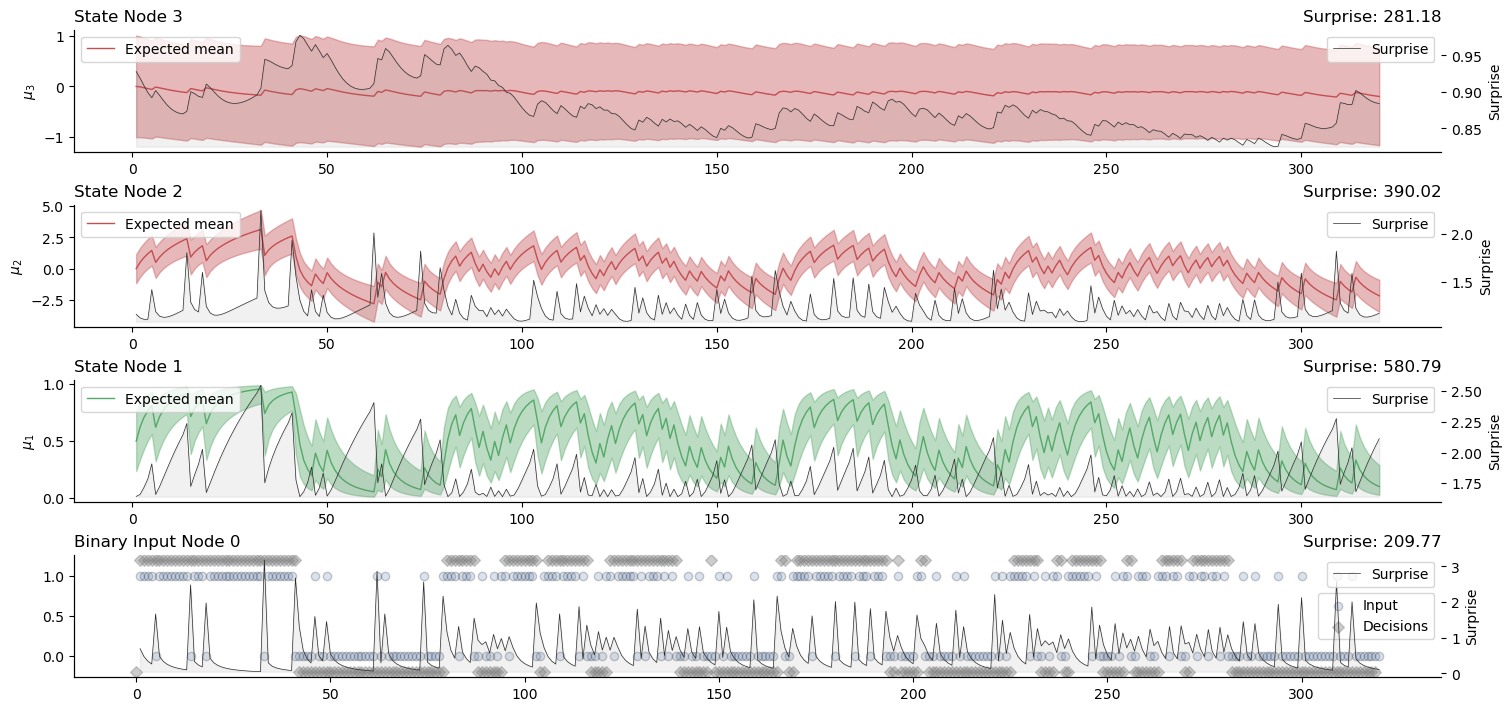

In [8]:
fig, axs = plt.subplots(figsize=(15, 7), nrows=4)

hgf_mcmc.plot_nodes(node_idxs=0, axs=axs[-1])
axs[-1].scatter(
    x=np.arange(len(y)),
    y=y * 1.4 - 0.2,
    label="Decisions",
    alpha=0.4,
    marker="D",
    color="grey",
)
axs[-1].legend()

hgf_mcmc.plot_nodes(node_idxs=1, axs=axs[-2], color="#55a868")
hgf_mcmc.plot_nodes(node_idxs=2, axs=axs[-3], color="#c44e52")
hgf_mcmc.plot_nodes(node_idxs=3, axs=axs[-4], color="#6d597a")

sns.despine()
plt.savefig("binary_trajectories.pdf", dpi=600)

## Traces

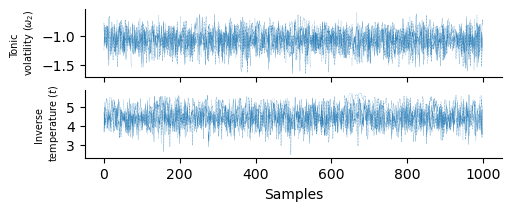

In [9]:
_, axs = plt.subplots(nrows=2, figsize=(5, 2), sharex=True)
for i, var_name in enumerate(["tonic_volatility_2", "inverse_temperature"]):
    for ii, st in zip(range(4), ["-", "--", ":", "-."]):
        axs[i].plot(
            two_level_hgf_idata["posterior"][var_name][ii],
            linewidth=0.2,
            color="#1f77b4",
            linestyle=st,
        )

axs[0].set_ylabel("Tonic \n volatility " r"($\omega_2$)", size=7)
axs[1].set_ylabel("Inverse \n temperature " r"($t$)", size=7)

axs[1].set_xlabel("Samples", size=10)
sns.despine()
plt.savefig("binary_traces.pdf", dpi=600)

## Posterior

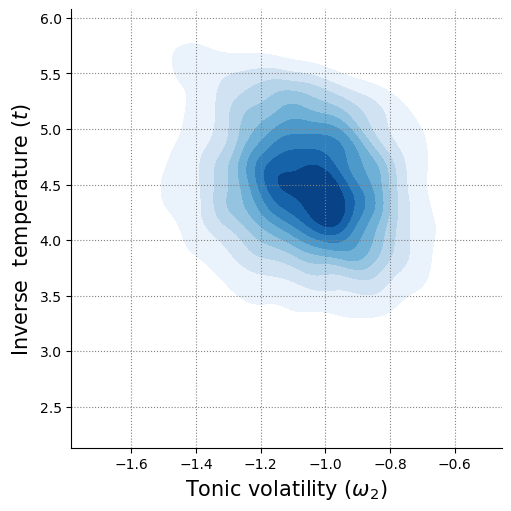

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.kdeplot(
    x=two_level_hgf_idata["posterior"]["tonic_volatility_2"].to_numpy().flatten(),
    y=two_level_hgf_idata["posterior"]["inverse_temperature"].to_numpy().flatten(),
    ax=ax,
    fill=True,
    cmap="Blues",
)
ax.grid(color="grey", linestyle="dotted", zorder=3)
ax.set_xlabel(r"Tonic volatility ($\omega_2$)", size=15)
ax.set_ylabel(r"Inverse  temperature ($t$)", size=15)
sns.despine()
plt.savefig("binary_posterior.pdf", dpi=600)

## Parameters recovery

In [6]:
N = 50  # the number of agents to simulate

# sample one value for the inverse temperature (here in log space) and simulate responses
temperatures = np.linspace(0.5, 6.0, num=N)

# sample one new value of the tonic volatility at the second level and fit to observations
volatilities = np.linspace(-5.5, -1.0, num=N)

In [7]:
def sigmoid(x, temperature):
    """The sigmoid response function with an inverse temperature parameter."""
    return (x**temperature) / (x**temperature + (1 - x) ** temperature)

In [8]:
# create just one default network - we will simply change the values of interest before fitting to save time
agent = HGF(
    n_levels=3,
    verbose=False,
    model_type="binary",
    initial_mean={"1": 0.5, "2": 0.0, "3": 0.0},
)

In [9]:
np.random.seed(123)

# observations (always the same), simulated decisions, sample values for temperature and volatility
responses = []
for i in range(N):
    # set the tonic volatility for this agent and run the perceptual model forward
    agent.attributes[2]["tonic_volatility"] = volatilities[i]
    agent.input_data(input_data=u)

    # get decision probabilities using the belief trajectories
    # and the sigmoid decision function with inverse temperature
    p = sigmoid(
        x=agent.node_trajectories[1]["expected_mean"], temperature=temperatures[i]
    )

    # save the observations and decisions separately
    responses.append(np.random.binomial(p=p, n=1))

responses = np.array(responses)

In [15]:
hgf_model_comparison_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :].repeat(
        N, axis=0
    ),  # the inputs are the same for all agents - duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

In [16]:
hgf_logp_op_pointwise = HGFPointwise(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :].repeat(
        N, axis=0
    ),  # the inputs are the same for all agents - duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

In [17]:
def logp(value, tonic_volatility_2, inverse_temperature):
    return hgf_model_comparison_logp_op(
        tonic_volatility_2=tonic_volatility_2,
        response_function_parameters=pt.flatten(inverse_temperature),
    )

In [18]:
def logp_pointwise(tonic_volatility_2, inverse_temperature):
    return hgf_logp_op_pointwise(
        tonic_volatility_2=tonic_volatility_2,
        response_function_parameters=inverse_temperature,
    )

In [19]:
with pm.Model() as two_levels_binary_hgf:

    response_data = pm.Data("response_data", responses, dims=["subject", "trials"])

    # tonic volatility
    tonic_volatility_2 = pm.Uniform(
        "tonic_volatility_2", -6.0, -0.5, shape=(N,), dims="subject"
    )

    # inverse temperature
    inverse_temperature = pm.Uniform(
        "inverse_temperature", 0.1, 7.0, shape=(N,), dims="subject"
    )

    # The multi-HGF distribution
    # --------------------------
    log_likelihood = pm.CustomDist(
        "log_likelihood",
        tonic_volatility_2,
        inverse_temperature,
        logp=logp,
        observed=response_data,
    )

    pm.Deterministic(
        "pointwise_loglikelihood",
        logp_pointwise(tonic_volatility_2, inverse_temperature),
        dims=["subject", "trials"],
    )

In [20]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tonic_volatility_2, inverse_temperature]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 299 seconds.
There were 1998 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [21]:
two_level_hgf_idata.add_groups(
    log_likelihood=two_level_hgf_idata.posterior["pointwise_loglikelihood"]
)

In [22]:
two_level_hgf_idata.to_netcdf("softmax_temperature.nc");

## Recovery plot

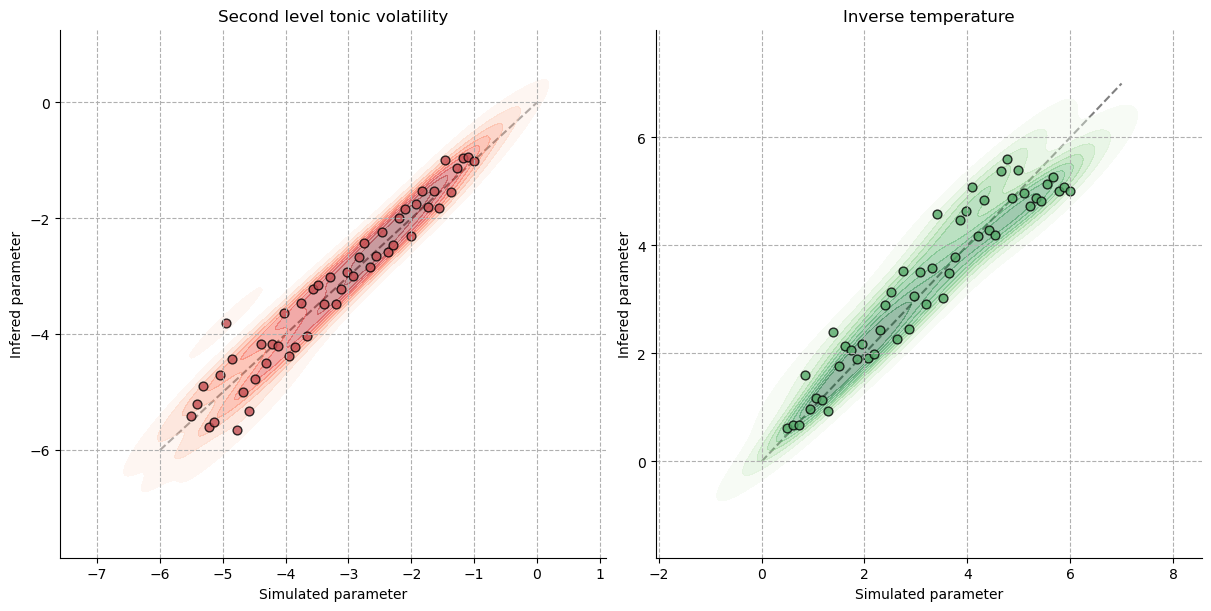

In [37]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)

axs[0].plot([-6.0, 0.0], [-6.0, 0.0], color="grey", linestyle="--", zorder=-1)
axs[1].plot([0.0, 7.0], [0.0, 7.0], color="grey", linestyle="--", zorder=-1)

for var_name, refs, idx in zip(
    ["tonic_volatility_2", "inverse_temperature"],
    [volatilities, temperatures],
    [0, 1],
):
    inferred_parameters = az.summary(two_level_hgf_idata, var_names=var_name)[
        "mean"
    ].tolist()

    sns.kdeplot(
        x=refs,
        y=inferred_parameters,
        ax=axs[idx],
        fill=True,
        cmap="Reds" if var_name == "tonic_volatility_2" else "Greens",
        alpha=0.4,
    )

    axs[idx].scatter(
        refs,
        az.summary(two_level_hgf_idata, var_names=var_name)["mean"].tolist(),
        s=40,
        alpha=0.8,
        edgecolors="k",
        color="#c44e52" if var_name == "tonic_volatility_2" else "#55a868",
    )

    axs[idx].grid(True, linestyle="--")
    axs[idx].set_xlabel("Simulated parameter")
    axs[idx].set_ylabel("Infered parameter")

axs[0].set_title("Second level tonic volatility")
axs[1].set_title("Inverse temperature")
plt.savefig("parameter_recovery.pdf", dpi=600)
sns.despine()

## Multilevel model

In [59]:
with pm.Model() as two_levels_binary_hgf_multilevel:

    response_data = pm.Data("response_data", responses, dims=["subject", "trials"])

    # tonic volatility
    # ----------------
    mu_volatility = pm.Normal("mu_volatility", -5, 5)
    sigma_volatility = pm.HalfNormal("sigma_volatility", 10)
    tonic_volatility_2 = pm.Normal(
        "tonic_volatility_2",
        mu=mu_volatility,
        sigma=sigma_volatility,
        shape=(N,),
        dims="subject",
    )

    # inverse temperature
    # -------------------
    mu_temperature = pm.HalfNormal("mu_temperature", 1)
    sigma_temperature = pm.HalfNormal("sigma_temperature", 0.5)
    inverse_temperature = pm.LogNormal(
        "inverse_temperature",
        mu_temperature,
        sigma_temperature,
        shape=(N,),
        dims="subject",
    )

    # The multi-HGF distribution
    # --------------------------
    log_likelihood = pm.CustomDist(
        "log_likelihood",
        tonic_volatility_2,
        pt.log(inverse_temperature),
        logp=logp,
        observed=response_data,
    )

In [60]:
with two_levels_binary_hgf_multilevel:
    two_level_hgf_multilevel_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_volatility, sigma_volatility, tonic_volatility_2, mu_temperature, sigma_temperature, inverse_temperature]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 249 seconds.
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


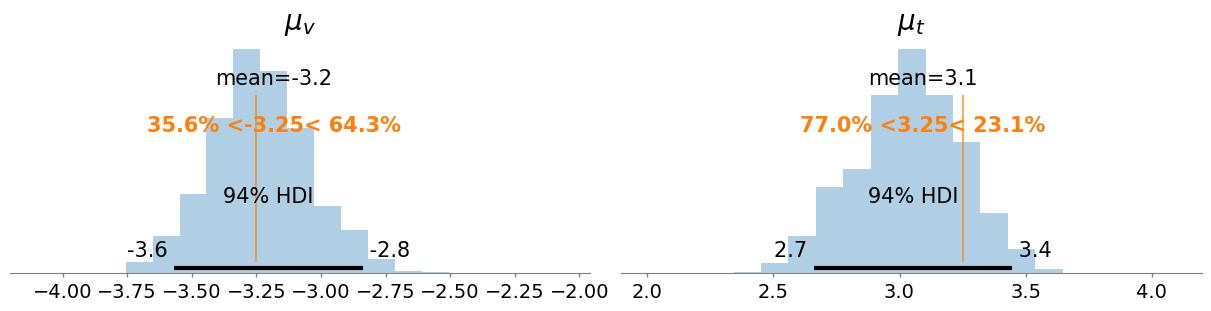

In [70]:
_, axs = plt.subplots(figsize=(12, 3), ncols=2)

az.plot_posterior(
    two_level_hgf_multilevel_idata,
    var_names=["mu_volatility", "mu_temperature"],
    ref_val=[volatilities.mean(), temperatures.mean()],
    kind="hist",
    ax=axs,
)

axs[0].set_title(r"$\mu_v$", size=20)
axs[1].set_title(r"$\mu_t$", size=20)
plt.savefig("multilevel.pdf", dpi=600)

## Model comparison

In [10]:
hgf_model_comparison_logp_op_softmax = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :].repeat(
        N, axis=0
    ),  # the inputs are the same for all agents - duplicate the array
    response_function=binary_softmax,
    response_function_inputs=responses,
)

In [11]:
hgf_logp_op_pointwise_softmax = HGFPointwise(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :].repeat(
        N, axis=0
    ),  # the inputs are the same for all agents - duplicate the array
    response_function=binary_softmax,
    response_function_inputs=responses,
)

In [12]:
def logp(value, tonic_volatility_2):
    return hgf_model_comparison_logp_op_softmax(
        tonic_volatility_2=tonic_volatility_2,
    )

In [13]:
def logp_pointwise(tonic_volatility_2):
    return hgf_logp_op_pointwise_softmax(
        tonic_volatility_2=tonic_volatility_2,
    )

In [14]:
with pm.Model() as two_levels_binary__sofmax_hgf:

    response_data = pm.Data("response_data", responses, dims=["subject", "trials"])

    # tonic volatility
    tonic_volatility_2 = pm.Uniform(
        "tonic_volatility_2", -7.0, -0.5, shape=(N,), dims="subject"
    )

    # The multi-HGF distribution
    # --------------------------
    log_likelihood = pm.CustomDist(
        "log_likelihood",
        tonic_volatility_2,
        logp=logp,
        observed=response_data,
    )

    pm.Deterministic(
        "pointwise_loglikelihood",
        logp_pointwise(tonic_volatility_2),
        dims=["subject", "trials"],
    )

In [15]:
with two_levels_binary__sofmax_hgf:
    two_level_hgf_softmax_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tonic_volatility_2]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 178 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
two_level_hgf_softmax_idata.add_groups(
    log_likelihood=two_level_hgf_softmax_idata.posterior["pointwise_loglikelihood"]
)

In [17]:
two_level_hgf_softmax_idata.to_netcdf("softmax.nc");

In [18]:
two_level_hgf_idata = az.from_netcdf("softmax_temperature.nc")
two_level_hgf_softmax_idata = az.from_netcdf("softmax.nc")

In [80]:
az.loo(two_level_hgf_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 16000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5980.93    62.99
p_loo       80.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     15852   99.1%
 (0.5, 0.7]   (ok)          95    0.6%
   (0.7, 1]   (bad)          2    0.0%
   (1, Inf)   (very bad)    51    0.3%

In [81]:
az.loo(two_level_hgf_softmax_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 16000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -7532.10    37.34
p_loo       23.24        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     15887   99.3%
 (0.5, 0.7]   (ok)          32    0.2%
   (0.7, 1]   (bad)         14    0.1%
   (1, Inf)   (very bad)    67    0.4%

In [19]:
compare_df = az.compare(
    {
        "softmax": two_level_hgf_softmax_idata,
        "temperature_softmax": two_level_hgf_idata,
    }
)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  good_k = min(1 - 1 / np.log10(n_samples), 0.7)
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  good_k = min(

In [20]:
compare_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
temperature_softmax,0,-5980.932152,80.340229,0.00000,1.0,62.990925,0.000000,True,log
softmax,1,-7531.972803,23.176449,1551.04065,0.0,37.347690,36.412179,True,log


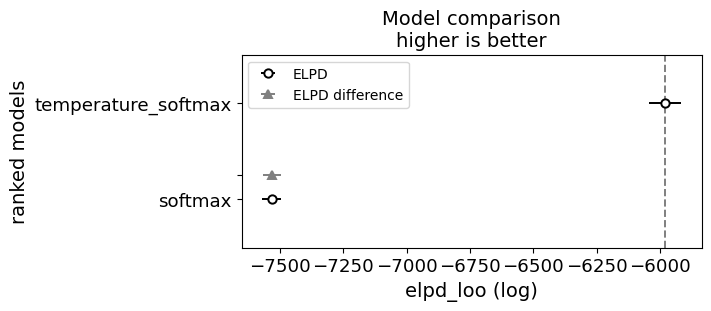

In [24]:
_, ax = plt.subplots(figsize=(7, 3))

az.plot_compare(compare_df, figsize=(9, 3), ax=ax)
plt.legend(loc="upper left")
plt.savefig("model_comparison.pdf", dpi=600)